In [2]:
import pandas as pd
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# 토큰화

In [39]:
okt = Okt()

In [40]:
okt.morphs('아 더빙 진짜 짜증나네요 목소리', stem = False)

['아', '더빙', '진짜', '짜증나네요', '목소리']

In [41]:
okt.morphs('아 더빙 진짜 짜증나네요 목소리', stem = True)

['아', '더빙', '진짜', '짜증나다', '목소리']

In [42]:
okt.nouns('아 더빙 진짜 짜증나네요 목소리')

['더빙', '진짜', '목소리']

In [43]:
okt.pos('아 더빙 진짜 짜증나네요 목소리')

[('아', 'Exclamation'),
 ('더빙', 'Noun'),
 ('진짜', 'Noun'),
 ('짜증나네요', 'Adjective'),
 ('목소리', 'Noun')]

In [44]:
# %%time 
# train_df['token'] = train_df['document'].map(lambda x: okt.morphs(x, stem = True))
# test_df['token'] = test_df['document'].map(lambda x: okt.morphs(x, stem = True))

In [45]:
# train_df.to_csv('nsmc_ratings_train_pre.csv', index = False)
# test_df.to_csv('nsmc_ratings_train_pre.csv', index = False)

In [46]:
train_df = pd.read_csv("./data/nsmc/nsmc_ratings_train_pre.csv")
test_df = pd.read_csv("./data/nsmc/nsmc_ratings_test_pre.csv")

In [47]:
type(train_df.loc[0, "token"])

str

In [48]:
# 혹시 문자열로 읽히면 리스트타입으로 바꾸는 법 
train_df['token'] = train_df['token'].map(lambda x: eval(x))
test_df['token'] = test_df['token'].map(lambda x: eval(x))

In [49]:
type(train_df.loc[0, "token"])

list

In [50]:
type(test_df.loc[0, "token"])

list

In [51]:
# train_df['token'] = train_df['token'].map(lambda x: [i for i in x if len(i) > 1])
# test_df['token'] = test_df['token'].map(lambda x: [i for i in x if len(i) > 1])

In [54]:
# 한글자 자리를 남김
train_df.head()

,id,document,label,token
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보다, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직하다, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이, 몬페, 그, 의, 익살스럽다, 연기, 가, 돋보이다, 영화, 스파이더맨, ..."


- 한글자씩이라 형태소분석을 하기가 좀 어려움, 전처리를 다시 해야함 

In [55]:
train_df.shape, test_df.shape

((143660, 4), (48403, 4))

In [56]:
train_df = train_df[train_df['token'].map(lambda x: len(x) > 0)]
test_df = test_df[test_df['token'].map(lambda x: len(x) > 0)]

In [57]:
train_df.shape, test_df.shape

((143660, 4), (48403, 4))

# 정수 인코딩

In [58]:
tokenizer = Tokenizer()

In [59]:
# 단어 집합 생성
# 등장 빈도 수가 높은 순서대로 정수값 부여 
tokenizer.fit_on_texts(train_df['token'])

In [60]:
# 단어 집합
tokenizer.word_index

{'이': 1,
 '영화': 2,
 '보다': 3,
 '하다': 4,
 '의': 5,
 '에': 6,
 '가': 7,
 '을': 8,
 '도': 9,
 '들': 10,
 '는': 11,
 '를': 12,
 '은': 13,
 '없다': 14,
 '이다': 15,
 '있다': 16,
 '좋다': 17,
 '너무': 18,
 '다': 19,
 '정말': 20,
 '한': 21,
 '되다': 22,
 '적': 23,
 '만': 24,
 '재밌다': 25,
 '같다': 26,
 '진짜': 27,
 '으로': 28,
 '로': 29,
 '아니다': 30,
 '않다': 31,
 '점': 32,
 '에서': 33,
 '만들다': 34,
 '과': 35,
 '나오다': 36,
 '연기': 37,
 '것': 38,
 '평점': 39,
 '내': 40,
 '최고': 41,
 '그': 42,
 '나': 43,
 '안': 44,
 '인': 45,
 '스토리': 46,
 '생각': 47,
 '못': 48,
 '왜': 49,
 '드라마': 50,
 '게': 51,
 '사람': 52,
 '감동': 53,
 '보고': 54,
 '이렇다': 55,
 '고': 56,
 '말': 57,
 '아깝다': 58,
 '더': 59,
 '배우': 60,
 '때': 61,
 'ㅋㅋ': 62,
 '와': 63,
 '아': 64,
 '감독': 65,
 '거': 66,
 '그냥': 67,
 '요': 68,
 '재미있다': 69,
 '재미': 70,
 '시간': 71,
 '내용': 72,
 '까지': 73,
 '뭐': 74,
 '중': 75,
 '주다': 76,
 '좀': 77,
 '자다': 78,
 '하고': 79,
 '지루하다': 80,
 '수': 81,
 '재미없다': 82,
 '네': 83,
 '쓰레기': 84,
 '모르다': 85,
 '가다': 86,
 '들다': 87,
 '그렇다': 88,
 '싶다': 89,
 '지': 90,
 '작품': 91,
 '사랑': 92,
 '알다': 93,
 '하나': 94

In [61]:
# 단어 등장 수 
tokenizer.word_counts

OrderedDict([('아', 4121),
             ('더빙', 572),
             ('진짜', 8288),
             ('짜증나다', 1002),
             ('목소리', 374),
             ('흠', 246),
             ('포스터', 572),
             ('보고', 4653),
             ('초딩', 422),
             ('영화', 50172),
             ('줄', 1240),
             ('오버', 142),
             ('연기', 6326),
             ('조차', 242),
             ('가볍다', 360),
             ('않다', 7718),
             ('너', 670),
             ('무재', 69),
             ('밓었', 1),
             ('다그', 75),
             ('래서', 20),
             ('보다', 40991),
             ('추천', 1180),
             ('한', 9615),
             ('다', 10077),
             ('교도소', 16),
             ('이야기', 2171),
             ('구먼', 11),
             ('솔직하다', 1199),
             ('재미', 3854),
             ('는', 16911),
             ('없다', 15519),
             ('평점', 6245),
             ('조정', 40),
             ('사이', 222),
             ('몬페', 2),
             ('그', 5667),
             ('의', 3073

In [63]:
total_cnt = len(tokenizer.word_index)
total_cnt

43770

In [79]:
tokenizer = Tokenizer(num_words = 30000)
tokenizer.fit_on_texts(train_df['token'])

In [67]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

In [68]:
print('단어 집합의 크기:', total_cnt)
print('등장 빈도가 %d번 이하인 희귀 단어의 수: %d' % (threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)

단어 집합의 크기: 43770
등장 빈도가 2번 이하인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.608864519076995
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5747898974035586


- 확인용, 실제 독립변수에 반영안함

In [80]:
# 35000개의 단어를 토큰으로 변화  
x_train = tokenizer.texts_to_sequences(train_df['token'])
x_test = tokenizer.texts_to_sequences(test_df['token'])

In [81]:
x_train

[[64, 473, 27, 278, 677],
 [965, 474, 54, 620, 2, 230, 1466, 37, 979, 694, 31],
 [403, 2460, 25033, 2330, 5684, 3, 237, 21, 19],
 [6507, 120, 8133, 234, 70, 11, 14, 39, 3619],
 [1041,
  19431,
  42,
  5,
  9158,
  37,
  7,
  849,
  2,
  2592,
  33,
  1126,
  256,
  4,
  14255,
  19432,
  7,
  1092,
  270,
  256],
 [739,
  5685,
  998,
  1405,
  443,
  159,
  1707,
  1640,
  11578,
  241,
  2,
  108,
  142,
  1109,
  9,
  58,
  261],
 [229, 5, 331, 8, 341, 503, 4],
 [142,
  1109,
  9,
  58,
  349,
  36,
  9801,
  14256,
  315,
  138,
  1600,
  1,
  385,
  135,
  242,
  20,
  817,
  29,
  597,
  592,
  536,
  493,
  3134,
  8134,
  24,
  1406,
  1406,
  1,
  50,
  11,
  301,
  9,
  14,
  37,
  48,
  4,
  52,
  24,
  721,
  1090,
  83],
 [110, 1, 14, 70, 16, 385, 113, 2],
 [1548, 39, 1, 217, 554, 97, 24, 21, 410, 1457, 378, 683, 18, 5686, 16],
 [399, 4704, 7, 183, 15, 27, 183, 15],
 [759,
  401,
  1243,
  220,
  389,
  5,
  2543,
  306,
  357,
  11579,
  11,
  621,
  2512,
  825,
  5,
  5

In [82]:
y_train = np.array(train_df['label'])
y_test = np.array(test_df['label'])

In [83]:
length = np.array([len(x) for x in x_train])

In [84]:
print(np.mean(length), np.min(length), np.median(length), np.max(length))

13.13909230126688 0 10.0 75


- 75 max는 정말 짧은 글이기 때문에 median을 쓰는 것보다 여기서는 max를 쓰는것도 괜찮음

## 모델

In [85]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,
                                                 stratify = y_train, random_state = 42)

In [86]:
train_seq = pad_sequences(x_train, maxlen = 80)
val_seq = pad_sequences(x_val, maxlen = 80)
test_seq = pad_sequences(x_test, maxlen = 80)

In [87]:
# Embedding 숫자 = num_words
# maxlen = input_shape
model = keras.Sequential()
model.add(keras.layers.Embedding(30000, 100, input_shape = (80,)))
model.add(keras.layers.LSTM(128, dropout = 0.4, return_sequences= True))
model.add(keras.layers.LSTM(128, dropout = 0.4))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [88]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 80, 100)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 80, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,248,961 (12.39 MB)

 Trainable params: 3,248,961 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

- 30000 개의 임베딩 뒤의 숫자 * 100 = 300만개의 파라미터가 됨 

In [89]:
adam = keras.optimizers.Adam(learning_rate = 0.005) # learning rate 를 살짝 높임 
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights= True)

In [90]:
history = model.fit(train_seq, y_train, epochs=100, batch_size = 128,
                    validation_data= (val_seq, y_val),
                    callbacks= [early_stopping_cb])

Epoch 1/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 191s 208ms/step - accuracy: 0.7850 - loss: 0.4390 - val_accuracy: 0.8516 - val_loss: 0.3424
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 187s 208ms/step - accuracy: 0.8787 - loss: 0.2880 - val_accuracy: 0.8496 - val_loss: 0.3526
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 193s 215ms/step - accuracy: 0.9053 - loss: 0.2318 - val_accuracy: 0.8478 - val_loss: 0.3764
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 179s 199ms/step - accuracy: 0.9212 - loss: 0.1958 - val_accuracy: 0.8490 - val_loss: 0.4057


- learning rate 가 0.005 너무 높아서 3 에포크 만에 과대적합이 뜬다.
- learning rate 를 더 낮춰야함 
- batch_size 는 너무 낮추면 128로 쓰는게 맞음 

In [93]:
def sent_predict(text):
    text = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', text)
    okt = Okt()
    text = okt.morphs(text, stem = True)
    encoded = tokenizer.texts_to_sequences([text])
    pad_new = pad_sequences(encoded, maxlen = 80)
    score = model.predict(pad_new)
    
    return score

In [95]:
sent_predict('영화 별로야')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.03727401]], dtype=float32)

In [96]:
sent_predict('시간낭비하기 좋아요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.09813919]], dtype=float32)

In [97]:
sent_predict('돈낭비는 즐거워')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[0.12479581]], dtype=float32)

In [98]:
sent_predict('엿같고 참 좋아요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.7355975]], dtype=float32)

- array가 0.5 이상으로 올라가야 긍정 

In [99]:
model.evaluate(test_seq, y_test)

1513/1513 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8499 - loss: 0.3404


[0.34474143385887146, 0.8488936424255371]

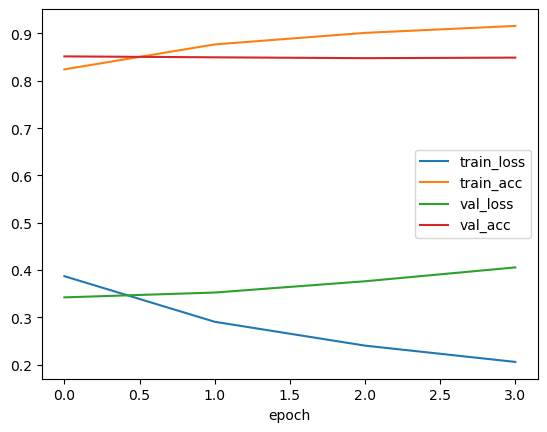

In [100]:
plt.figure()

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_acc')

plt.legend()
plt.xlabel('epoch')
plt.show()

- bert
- transformer 모델이 NLP 에서 잘 적용됨

#### 우영님 레시피

In [102]:
# model = keras.Sequential()
# model.add(keras.layers.Embedding(30000, 100, input_shape = (75,)))

# model.add(keras.layers.GRU(128, return_sequences = True))
# model.add(keras.layers.Dense(64, activation = "relu"))
# model.add(keras.layers.GRU(128, return_sequences = True))
# model.add(keras.layers.Dense(64, activation = "relu"))
# model.add(keras.layers.GRU(64))

# model.add(keras.layers.Dense(1, activation = "sigmoid"))

# opt = keras.optimizers.RMSprop(learning_rate = 0.0005)
# model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])
# early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

# history = model.fit(train_seq, y_train2, batch_size = 64, epochs = 100, validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])
